In [121]:
from pathlib import Path
import pickle
import sys

sys.path.append('/data/condor_shared/users/ssued/RNOGCnn')
import utils

data_path = Path("data/")
event_path = data_path / 'eventbatch_k'

eventbatch = utils.obtain_evb('eventbatch.pkl')

with open(event_path, 'rb') as file:
    eventbatch_k = pickle.load(file)

In [122]:
# Split the eventbatch_k into 75% training and 25% testing
# Calculate the split index
split_index = int(len(eventbatch) * 0.75)

# Split the eventbatch_k into 75% training and 25% testing
train_eventbatch = dict(list(eventbatch.items())[:split_index])
test_eventbatch = dict(list(eventbatch.items())[split_index:])

print(f'Size of train_eventbatch = {len(train_eventbatch.keys())}')
print(f'Size of test_eventbatch = {len(test_eventbatch.keys())}')

Size of train_eventbatch = 3741
Size of test_eventbatch = 1248


In [123]:
from torch.utils.data import Dataset
from typing import Tuple, Dict, List
from torch.nn.functional import normalize
import numpy as np
import torch

# Custom dataset class to work with dictionaries

class EventtoData(Dataset):
    """
    Custom Dataset class for handling event data.

    Attributes:
    -----------
    events : np.ndarray
        Array containing event data.
    n_channels : int
        Number of channels in the event data.
    n_bins : int
        Number of bins in the event data.
    bin_time : float
        Time duration of each bin.
    transform : callable, optional
        Optional transform to be applied on a sample (currently deprecated).

    Methods:
    --------
    __len__() -> int:
        Returns the number of events.
    __getitem__(index: int) -> Tuple[np.ndarray, float]:
        Returns a tuple (data, mean_SNR) for the given index.
    show_event(index: int):
        Displays the event data as an image using a utility function.
    mean_snr_of(index: int) -> float:
        Returns the mean SNR of the event at the given index.

    Notes:
    ------
    - The class now supports initialization with either an events dictionary or a file containing events.
    - The event data is converted from a dictionary to a numpy array for easier handling.
    - The `__getitem__` method ensures that the data includes a color dimension and converts data types to float32.
    """
    def __init__(self, events=None, events_f=None, transform=None):
        if not events_f and not events:
            raise ValueError("Must include either events file or events to construct EventData object.")
        if events_f:
            with open(events_f, 'rb') as file:
                events_dict = pickle.load(file)
        else:
            events_dict = events

        # Must convert from dictionary to arrays
        self.events = np.array([events[key] for key in events.keys()])
        first_key = next(iter(events_dict))
        self.n_channels = events_dict[first_key]['data'].shape[0]
        self.n_bins = events_dict[first_key]['data'].shape[1]
        self.bin_time = events_dict[first_key]['bin_time'].item()
        self.transform = transform # deprecated for now

    def show_event(self, index : int):
        utils.plot_image(self.events[index])

    def mean_snr_of(self, index : int):
        return self.events[index]['mean_SNR'].item()

    def __len__(self) -> int:
        return len(self.events)

    # Must overwrite __getitem__():
    def __getitem__(self, index : int) -> Tuple:
        item_data_uncolored = self.events[index]['data']
        item_data = torch.tensor(np.array([item_data_uncolored]).astype('float32')) # Must add a color dimension
        item_snr = torch.tensor(np.array(self.events[index]['mean_SNR']).astype('float32'))

        item = (normalize(item_data),item_snr)

        return item # Returns (data, mean_SNR)

In [124]:
# Prepare data into DataLoader
from torch.utils.data import DataLoader

train_data = EventtoData(train_eventbatch)
test_data = EventtoData(test_eventbatch)

BATCH_SIZE = 50 # Small batch size just to test batch size feature

train_data_loader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle=False)
test_data_loader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [125]:
from torch import nn
# Let there be light!
    
class RNOG_CNN_alpha_1(nn.Module):

    def __init__(self,input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        KERNEL_WIDTH = 5
        KERNEL_HEIGHT = 2
        KERNEL_SIZE = (KERNEL_HEIGHT,KERNEL_WIDTH)

        self.conv_block_1=nn.Sequential( # Blocks are collections of layers
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(3,12),
                      stride=1), # Establish hyper parameters #
            #nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=output_shape,
                      kernel_size=(2,14), # Will output (1,10)
                      stride=1),
            #nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units,
            #           out_channels=hidden_units,
            #           kernel_size=(2,4), 
            #           stride=1),
            # #nn.ReLU(),
            # nn.Conv2d(in_channels=hidden_units,
            #           out_channels=output_shape,
            #           kernel_size=(1,5),
            #           stride=1)
        )

    def forward(self,x):
        x = self.conv_block_1(x)
        return x

In [126]:
from torchinfo import summary
model_test = RNOG_CNN_alpha_1(1,10,1)

summary(model_test, input_size=[1, 1, 4, 25]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
RNOG_CNN_alpha_1                         [1, 1, 1, 1]              --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv2d: 2-1                       [1, 10, 2, 14]            370
│    └─Conv2d: 2-2                       [1, 1, 1, 1]              281
Total params: 651
Trainable params: 651
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01

In [127]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [128]:
# Train_step function:

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss
    #train_loss = 0
    train_loss_arr = []
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        y = y.view_as(y_pred)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        #train_loss += loss.item()
        train_loss_arr.append(loss)

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Adjust metrics to get average loss per batch
    #train_loss = train_loss / len(dataloader)
    train_loss = max(train_loss_arr)

    return train_loss

In [129]:
# Test step function:

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test values
    #test_loss = 0
    test_loss_arr = []

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred = model(X)
            y = y.view_as(test_pred)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred, y)
            #test_loss += loss.item()
            test_loss_arr.append(loss)
            
    # Adjust metrics to get average loss per batch 
    #test_loss = test_loss / len(dataloader)
    test_loss = max(test_loss_arr)
    return test_loss

In [130]:
# Train function (Combines both steps)

from torch.optim.lr_scheduler import ExponentialLR
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler.LRScheduler,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          targ_loss = 0):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
               "test_loss": [],
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss = train_step(model=model,
                                dataloader=train_dataloader,
                                loss_fn=loss_fn,
                                optimizer=optimizer)
        test_loss = test_step(model=model,
                              dataloader=test_dataloader,
                              loss_fn=loss_fn)
        if scheduler:
            scheduler.step()

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch} | "
            f"train_loss: {train_loss:.10f} | "
            f"test_loss: {test_loss:.10f} | "
        )
        if scheduler:
            print(f"learning_rate: {scheduler.get_last_lr():.10f}")


        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)

        if targ_loss != 0:
            #epochs += 1
            curr_loss = results['train_loss'][epoch]
            if curr_loss <= targ_loss:
                break

    # 6. Return the filled results at the end of the epochs
    return results

In [131]:
# Set number of epochs
NUM_EPOCHS = 10000

# Create model_1
model_1 = RNOG_CNN_alpha_1(input_shape=1, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=1)

# Setup loss function and optimizer
loss_fn = nn.MSELoss()
#loss_fn = nn.HuberLoss(delta=0.01)
#loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(params=model_1.parameters())
scheduler = False#ExponentialLR(optimizer, gamma=0.9)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_1_results = train(model=model_1, 
                        train_dataloader=train_data_loader,
                        test_dataloader=test_data_loader,
                        optimizer=optimizer,
                        scheduler=scheduler,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        targ_loss=10)
    
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 0 | train_loss: 170.3528137207 | test_loss: 10.0248327255 | 
Epoch: 1 | train_loss: 171.2724456787 | test_loss: 10.0572042465 | 
Epoch: 2 | train_loss: 171.1938323975 | test_loss: 10.0418796539 | 
Epoch: 3 | train_loss: 171.1125946045 | test_loss: 10.0250778198 | 
Epoch: 4 | train_loss: 171.0181427002 | test_loss: 10.0119676590 | 
Epoch: 5 | train_loss: 170.9223785400 | test_loss: 10.0019979477 | 
Epoch: 6 | train_loss: 170.8283843994 | test_loss: 9.9941768646 | 
Epoch: 7 | train_loss: 170.7358398438 | test_loss: 9.9877414703 | 
Epoch: 8 | train_loss: 170.6431884766 | test_loss: 9.9821395874 | 
Epoch: 9 | train_loss: 170.5489654541 | test_loss: 9.9769916534 | 
Epoch: 10 | train_loss: 170.4515686035 | test_loss: 9.9720039368 | 
Epoch: 11 | train_loss: 170.3495178223 | test_loss: 9.9669198990 | 
Epoch: 12 | train_loss: 170.2412872314 | test_loss: 9.9614915848 | 
Epoch: 13 | train_loss: 170.1255493164 | test_loss: 9.9554576874 | 
Epoch: 14 | train_loss: 170.0008239746 | test_loss: 

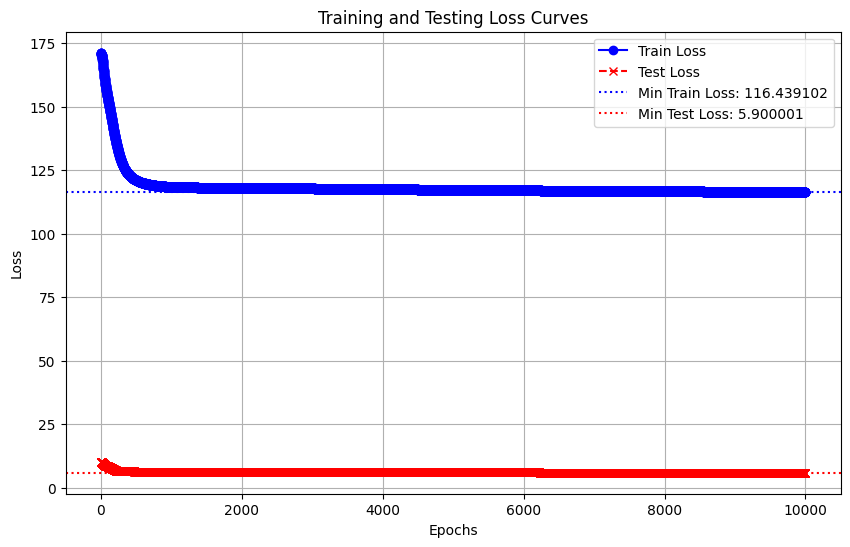

In [132]:
import matplotlib.pyplot as plt

# Plot loss curves with improved aesthetics:
epochs = np.arange(NUM_EPOCHS)
train_loss = model_1_results['train_loss']
test_loss = model_1_results['test_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(epochs, test_loss, label='Test Loss', color='red', linestyle='--', marker='x')

# Plot minimum loss horizontal lines
min_train_loss = min(train_loss)
min_test_loss = min(test_loss)
plt.axhline(y=min_train_loss, color='blue', linestyle=':', label=f'Min Train Loss: {min_train_loss:.6f}')
plt.axhline(y=min_test_loss, color='red', linestyle=':', label=f'Min Test Loss: {min_test_loss:.6f}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.grid(True)
plt.show()

In [133]:
import random

eventbatch = utils.obtain_evb('eventbatch.pkl')
# Select 20 random events from eventbatch
random_events = dict(random.choices(list(eventbatch.items()), k=20))

random_data = EventtoData(random_events)

random_dataloader = DataLoader(random_data,1,False)

model_1.eval()
loss_fn = nn.MSELoss()

with torch.inference_mode():
    for i, (data, snr) in enumerate(random_dataloader):
        data, snr = data.to(device), snr.to(device)
        pred = model_1(data)
        loss = loss_fn(pred, snr)
        print(f"Data Point {i + 1}: Loss = {loss.item():.6f}")

Data Point 1: Loss = 0.534524
Data Point 2: Loss = 0.000316
Data Point 3: Loss = 1.849320
Data Point 4: Loss = 0.269094
Data Point 5: Loss = 0.485888
Data Point 6: Loss = 0.000406
Data Point 7: Loss = 0.107115
Data Point 8: Loss = 0.052681
Data Point 9: Loss = 0.117072
Data Point 10: Loss = 0.078168
Data Point 11: Loss = 0.059000
Data Point 12: Loss = 0.811219
Data Point 13: Loss = 1.232294
Data Point 14: Loss = 1.117391
Data Point 15: Loss = 1.128440
Data Point 16: Loss = 0.001551
Data Point 17: Loss = 0.042643
Data Point 18: Loss = 0.168467
Data Point 19: Loss = 1.147440
Data Point 20: Loss = 0.065877


/data/i3home/ssued/venv_ubu22.04/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


First 10 predictions (Predicted SNR, True SNR):
Sample 1: Predicted = 2.6972529888153076, True = 3.4283645153045654
Sample 2: Predicted = 3.3044443130493164, True = 3.3222167491912842
Sample 3: Predicted = 4.5270366668701172, True = 3.1671395301818848
Sample 4: Predicted = 2.5971875190734863, True = 3.1159298419952393
Sample 5: Predicted = 2.6253314018249512, True = 3.3223881721496582
Sample 6: Predicted = 3.2968165874481201, True = 3.3169670104980469
Sample 7: Predicted = 3.5233242511749268, True = 3.1960403919219971
Sample 8: Predicted = 4.3242530822753906, True = 4.5537772178649902
Sample 9: Predicted = 3.6842732429504395, True = 3.3421146869659424
Sample 10: Predicted = 2.9123375415802002, True = 3.1919224262237549


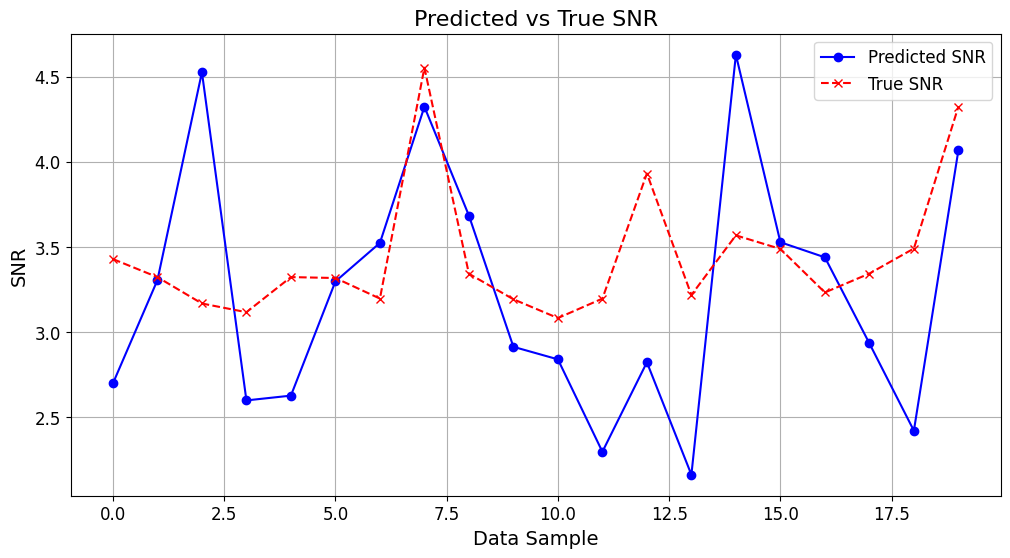

In [134]:
def make_predictions(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device = device, plot: bool = False, verbose: bool = False):
    predictions = []
    model.eval()
    with torch.inference_mode():
        for data, snr in dataloader:
            data = data.to(device)
            pred = model(data)
            predictions.append((pred.cpu().item(), snr.cpu().item()))

    if verbose:
        print("First 10 predictions (Predicted SNR, True SNR):")
        for i, (pred, true) in enumerate(predictions[:10]):
            print(f"Sample {i + 1}: Predicted = {pred:.16f}, True = {true:.16f}")

    if plot:
        pred_values, true_values = zip(*predictions)
        samples = np.arange(len(pred_values))

        plt.figure(figsize=(12, 6))
        plt.plot(samples, pred_values, label='Predicted SNR', marker='o', linestyle='-', color='blue')
        plt.plot(samples, true_values, label='True SNR', marker='x', linestyle='--', color='red')
        plt.xlabel('Data Sample', fontsize=14)
        plt.ylabel('SNR', fontsize=14)
        plt.title('Predicted vs True SNR', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.show()

    return predictions

preds = make_predictions(model_1, random_dataloader, device=device, plot=True,verbose=True)


In [135]:
model_1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-4.4475e-03, -5.5405e-03,  6.6097e-04,  1.2123e-02,  1.5490e-02,
                          9.6816e-03,  9.1348e-03,  9.3362e-03,  2.8032e-02,  3.8444e-02,
                          2.7945e-02,  3.1782e-02],
                        [ 1.6817e-02,  2.3898e-02,  4.1770e-02,  3.6497e-02,  5.1481e-02,
                          4.8207e-02,  1.9920e-02,  3.9855e-02,  4.0332e-02,  5.2953e-02,
                          2.0110e-03,  4.5147e-02],
                        [ 1.5508e-02,  1.5697e-02,  2.2490e-02,  1.2571e-02,  8.5291e-03,
                         -2.8816e-03, -8.2365e-03, -1.0834e-02, -4.3245e-03,  2.6685e-02,
                          1.1218e-02,  1.6262e-02]]],
              
              
                      [[[ 1.5107e-01, -1.8877e-01, -1.9741e-01, -5.4915e-01, -2.8792e-01,
                          1.2915e-01, -2.2034e-01, -7.7627e-01,  9.0210e-02,  1.1021e+00,
                          8.1549e-01, -1.1554e+00],
 

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save path
MODEL_NAME='RNOG_alpha_model_1.pth'
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)